# 080. seq2seq language translation

### Encoder-Decoder model


- Seq2seq language translation 의 decoder 부분은 Language Model 의 text poetry generation 과 동일함  


- 영어-한국어 번역

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
BATCH_SIZE = 64
LATENT_DIM = 256                # encoding space 의 latent dimensionality
NUM_SAMPLES = 10000         # number of samples to train on
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100

## 입력 data list 작성  

### 1. input_texts     : original language 의 input text  


### 2. Teacher Forcing 용 input / target data 생성

- target_texts_inputs  : 1 만큼 offset 된 target language sentence $\rightarrow$ `<sos>....`  
- target_texts  : target language sentence  $\rightarrow$ `.....<eos>`



- data 는 http://www.manythings.org/anki/  (Tab-delimited Bilingual Sentence Pairs) 에서 download  


    - English(input) + `\t` + The Other Language(target) + `\t` + Attribution(기여자) 형식으로 구성 
        ex)
        - Hi.	안녕.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee)
        
   

In [3]:
file_path = tf.keras.utils.get_file("kor.txt",
                 "https://github.com/ironmanciti/NLP_lecture/raw/master/data/kor.txt")

In [4]:
# load in the data
original_texts = []
translation_inputs = []
translation_targets = []

# load data
for line in open(file_path, 'r', encoding='utf-8'):
   
    if '\t' not in line:     # next line 이동
        continue
        
    # input 과 target translation 구분
    input_text, translation, attribution = line.split('\t')
        
    # target input 과 output 을 teacher forcing 입력 구성
    translation_input = '<sos> ' + translation
    translaton_target = translation + ' <eos>'

    original_texts.append(input_text)     # original text
    
    translation_inputs.append(translation_input)   
    translation_targets.append(translaton_target)

print("num_samples :", len(original_texts))

num_samples : 3318


In [5]:
print("Original Input :")
print(original_texts[1100:1110])
print("\nTeacher Forcing Input :")
print(translation_inputs[1100:1110])
print("\nTeacher Forcing Target")
print(translation_targets[1100:1110])

Original Input :
["Don't lie anymore, OK?", "Don't you laugh at me.", 'French is fascinating.', 'French is interesting.', 'French is very useful.', 'He looked quite tired.', 'He was about to speak.', 'He was born in Africa.', 'I called Tom for help.', "I didn't come by taxi."]

Teacher Forcing Input :
['<sos> 거짓말 하지 마세요, 알았죠?', '<sos> 날 비웃지마.', '<sos> 프랑스어는 매력적이야.', '<sos> 프랑스어는 흥미로워.', '<sos> 프랑스어는 아주 유용해.', '<sos> 그사람은 좀 지쳐보였어.', '<sos> 그사람이 말하려고 했어.', '<sos> 그는 아프리카에서 태어났다.', '<sos> 나는 톰에게 도움을 요청했다.', '<sos> 택시로 안 왔어.']

Teacher Forcing Target
['거짓말 하지 마세요, 알았죠? <eos>', '날 비웃지마. <eos>', '프랑스어는 매력적이야. <eos>', '프랑스어는 흥미로워. <eos>', '프랑스어는 아주 유용해. <eos>', '그사람은 좀 지쳐보였어. <eos>', '그사람이 말하려고 했어. <eos>', '그는 아프리카에서 태어났다. <eos>', '나는 톰에게 도움을 요청했다. <eos>', '택시로 안 왔어. <eos>']


## Tokenization

- language 가 2 개 이므로 언어별로 서로 다른 tokenizer 생성. 따라서, 2 개의 word_index 구성

### Input Text 의 tokenize

In [6]:
original_texts[1500:1505]

['Yesterday was a good day.',
 "You can't erase the past.",
 'You have to study French.',
 'You need to study French.',
 'You should exercise more.']

In [7]:
tokenizer_original = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_original.fit_on_texts(original_texts)

original_sequences = tokenizer_original.texts_to_sequences(original_texts)
original_sequences[1500:1505]

[[126, 12, 6, 94, 153],
 [4, 68, 1547, 7, 449],
 [4, 17, 3, 142, 29],
 [4, 116, 3, 142, 29],
 [4, 119, 961, 89]]

In [8]:
word2idx_original = tokenizer_original.word_index
print(f'unique input token 수 : {len(word2idx_original)}')

num_words_original = min(MAX_VOCAB_SIZE, len(word2idx_original) + 1)
print("Input Text 의 단어 수 :", num_words_original)

max_len_original = max(len(s) for s in original_sequences)
print("Input Text 의 최대 길이 :", max_len_original)

unique input token 수 : 2395
Input Text 의 단어 수 : 2396
Input Text 의 최대 길이 : 101


### Target Text 의 tokenize 

In [9]:
print(translation_inputs[1500:1504])
print(translation_targets[1500:1504])

['<sos> 어제는 좋은 날이었다.', '<sos> 과거를 지울 순 없어.', '<sos> 넌 프랑스어를 공부해야 돼.', '<sos> 넌 프랑스어를 공부할 필요가 있어.']
['어제는 좋은 날이었다. <eos>', '과거를 지울 순 없어. <eos>', '넌 프랑스어를 공부해야 돼. <eos>', '넌 프랑스어를 공부할 필요가 있어. <eos>']


### input language 의 tokenize
- 주의 사항 : $<sos>, <eos>$때문에 special character 를 filtering 하면 안됨

In [10]:
tokenizer_translation = Tokenizer(num_words=MAX_VOCAB_SIZE, filters="")
tokenizer_translation.fit_on_texts(translation_inputs + translation_targets) 

translation_input_sequences  = tokenizer_translation.texts_to_sequences(translation_inputs)
translation_target_sequences = tokenizer_translation.texts_to_sequences(translation_targets)

print(translation_input_sequences[1500:1504])
print(translation_target_sequences [1500:1504])

[[1, 1164, 87, 2706], [1, 696, 2707, 2708, 21], [1, 52, 37, 548, 124], [1, 52, 37, 2709, 247, 6]]
[[1164, 87, 2706, 2], [696, 2707, 2708, 21, 2], [52, 37, 548, 124, 2], [52, 37, 2709, 247, 6, 2]]


### output language 의 tokenize

In [11]:
word2idx_translation = tokenizer_translation.word_index
print(f'unique output tokens : {len(word2idx_translation)}')

num_words_translation = len(word2idx_translation) +1
print("Target 언어의 단어 수 :", num_words_translation)

max_len_translation = max(len(s) for s in translation_target_sequences)
print("Target 언어의 최대 길이 :", max_len_translation )

unique output tokens : 5324
Target 언어의 단어 수 : 5325
Target 언어의 최대 길이 : 90


## sequence padding


#### 주의 사항
- encoder 는 thought vector 생성 목적이므로 default (pre) 로 padding

- decoder 는 teacher forcing 을 해야하므로 post 로 padding

In [12]:
encoder_inputs = pad_sequences(original_sequences, maxlen=max_len_original)
print("encoder input shape :", encoder_inputs.shape)
print("encoder_inputs[0] : ", encoder_inputs[1500])

decoder_inputs = pad_sequences(translation_input_sequences, maxlen=max_len_translation, padding="post")
print("\ndecoder input shape :", decoder_inputs.shape)
print("decoder_inputs[0] : ", decoder_inputs[1500])

decoder_targets = pad_sequences(translation_target_sequences, maxlen=max_len_translation, padding="post")
print("\nencoder target shape :", decoder_targets.shape)
print("encoder_targets[0] : ", decoder_targets[1500])

encoder input shape : (3318, 101)
encoder_inputs[0] :  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 126  12   6  94 153]

decoder input shape : (3318, 90)
decoder_inputs[0] :  [   1 1164   87 2706    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]

encoder target shape

## pretrained word embedding 값을 transfer learning

- Embedding layer 의 weight 를 pre-trained model 로 초기화  


- glove.6B 의 EMBEDDING_DIM version 사용  
    - space 로 구분된 text file 
    - 첫번째는 word 이고 두번째 이후는 weight vector 값이다


- word index 가 1 부터 시작하므로 0 padding 감안하여 num_words 는 len(word2idx)+1, 혹은 MAX_VOCAB_SIZE 중 작은 것 선택  


- embedding_dict dictionary : key - word, value - embedding_vector

In [13]:
glove_path = tf.keras.utils.get_file("glove.6B.100d.txt", 
             "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt")

In [14]:
def make_embedding(transfer_learning=True):

    embeddings_dict = {}

    with open(glove_path, encoding="utf8") as f:
        for i, line in enumerate(f):
            values = line.split()                                           # 각 줄을 읽어와서 word_vector에 저장
            word = values[0]                                              # 첫번째 값은 word
            coefs = np.asarray(values[1:], dtype='float32')  # 두번째 element 부터 마지막까지 100 개는 해당 단어의 임베딩 벡터의  값
            embeddings_dict[word] = coefs
                
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))    # zero 로 초기화   
    
    if transfer_learning:    
        print("word 갯수 =", num_words)
        print(embedding_matrix.shape)

        for word, i in word2idx_original.items():
            if i < MAX_VOCAB_SIZE:
                embedding_vector = embeddings_dict.get(word)
                if embedding_vector is not None:       # 해당 word 가 없으면 all zero 로 남겨둠
                    embedding_matrix[i] = embedding_vector
                    
    return embedding_matrix

In [15]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx_original) + 1)

### embedding layer 작성

- encoder 와 decoder 의 Embedding layer 에 pre-trained embedding weight 를 초기값으로 load

In [16]:
# create embedding layer
embedding_matrix = make_embedding(transfer_learning=True)
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)

word 갯수 = 2396
(2396, 100)


## Build the model

- encoder 와 decoder 의 embedding, lstm 및 dense layer 를 training 할 목적의 model 작성  

- encoder 는 decoder 에 states [h, c] 만 전달

- prediction 을 위한 model 은 training model 에서 만들어진 layer 들의 weight 를 이용하여 별도 작성  

### Training : Encoder + Teacher Forcing model

In [17]:
# Encoder
encoder_inputs_ = Input(shape=(max_len_original), name='Encoder_Input')

# pre-trained embedding layer 사용
x = embedding_layer(encoder_inputs_)

encoder_outputs, h, c = LSTM(LATENT_DIM, return_state=True)(x)

# encoder 는 hidden state and cell state 만 decoder 로 전달 --> thought vector
encoder_states = [h, c]

# Decoder
# decoder 는 [h, c] 를 initial state 로 사용
decoder_inputs_ = Input(shape=(max_len_translation,), name="Decoder_Input")

# decode word embedding 은 pre-trained vector 를 사용 않음
decoder_embedding = Embedding(num_words_translation, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# final layer
decoder_dense = Dense(num_words_translation, activation='softmax', name='Decoder_Output')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model_teacher_forcing = Model([encoder_inputs_, decoder_inputs_], decoder_outputs)

#Compile the model and train it
model_teacher_forcing.compile(loss='sparse_categorical_crossentropy', 
                              optimizer='rmsprop', metrics=['accuracy'])

model_teacher_forcing.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input (InputLayer)      [(None, 101)]        0                                            
__________________________________________________________________________________________________
Decoder_Input (InputLayer)      [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 101, 100)     239600      Encoder_Input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 90, 256)      1363200     Decoder_Input[0][0]              
______________________________________________________________________________________________

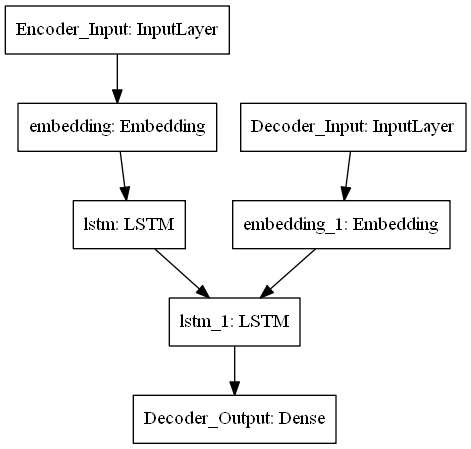

In [18]:
plot_model(model_teacher_forcing)

In [ ]:
history = model_teacher_forcing.fit([encoder_inputs, decoder_inputs], decoder_targets, 
                         batch_size=BATCH_SIZE, epochs=40, validation_split=0.2)

In [ ]:
# plot some data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend()

# accuracies
ax2.plot(history.history['accuracy'], label='acc')
ax2.plot(history.history['val_accuracy'], label='val_acc')
ax2.legend()
plt.show()

In [ ]:
# save model
model_teacher_forcing.save('seq2seq_translation.h5')

### Make Predictions - Inference phase

- prediction 을 위한 별도의 encoder model 
- encoder 의 states 를 initial state 로 받는 decoder model 작성  

- encoder 는 training 단계와 동일하게 input_text 를 입력으로 받고 encoder_states 를 출력으로 하므로 이전에 define 한 encoder_input_ 과 encoder_states 변수 재사용

In [ ]:
# Encoder
encoder_model = Model(encoder_inputs_, encoder_states)

# Decoder
decoder_state_input_h = Input(shape=(LATENT_DIM,), name='Decoder_hidden_h')
decoder_state_input_c = Input(shape=(LATENT_DIM,), name='Decoder_hidden_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,), name='Decoder_input')
x = decoder_embedding(decoder_inputs_single)

# output, hidden states 를 저장
decoder_outputs, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)

decoder_states = [h, c]

decoder_outputs = decoder_dense(decoder_outputs)  

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,    #decoder_model.predict([target_seq] + states_value)
    [decoder_outputs] + decoder_states
)

encoder_model.summary()

decoder_model.summary()

In [ ]:
plot_model(encoder_model)

In [ ]:
plot_model(decoder_model)

In [ ]:
# reverse word2idx dictionary to get back words during prediction
idx2word_original = dict((i, w) for w, i in word2idx_original.items())

idx2word_translation = dict((i, w) for w, i in word2idx_translation.items())

In [ ]:
def decode_sequence(input_seq):
   # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

   # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

   # target sequence 의 첫번째 character 를 start character (<sos>) 로 설정 
   # [[2.]]
    target_seq[0, 0] = word2idx_translation['<sos>']

   # <eos> 가 decode 에서 생성되면 break
    eos = word2idx_translation['<eos>']

   # Create the translation
    output_sentence = []
    for _ in range(max_len_translation):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

       # argmax 로 가장 확률 높은 단어 선택 --> greedy selection
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:  # End sentence of EOS
            break

        word = ''
        if idx > 0:      # idx 0 은 zero padding 된 sequence 이므로 skip
            word = idx2word_translation[idx]
            output_sentence.append(word)

        # 생성된 word 를 decoder 의 다음 input 으로 사용
        target_seq[0, 0] = idx

       # Update states
        states_value = [h, c]

    return ' '.join(output_sentence)

for _ in range(5):
    i = np.random.choice(len(original_texts))
    input_seq = encoder_inputs[i:i+1]
    
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', original_texts[i])
    print('Translation:', translation)

In [ ]:
txt = "Your lips are red."
input_sequence = tokenizer_original.texts_to_sequences([txt])
encoder_input = pad_sequences(input_sequence, maxlen=max_len_original)

translation = decode_sequence(encoder_input)
print('-')
print('Input:', txt)
print('Translation:', translation)